## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# plt.style.use('dark_background')

### Perceptual decision makingg

__1. Create a function for generating the data.__

In [2]:
# defining standard deviation and strength of stimulus
std = 0.03
stim_strength = std * np.hstack((-np.flip(2**np.arange(0,5)), 2**np.arange(0,5)))


In [3]:

def generate_data(trials, length, stim_strength, std = 0.03):
    """
    ksi is a normally distr noise with sigma 0.03.
    u is an input
    û is the stimulis strength
    y is the target, i.e. the sign of û
    """
    ksi = std * np.random.randn(trials, length)
    
  
    û_value = np.random.choice(stim_strength, trials)
    û = np.full_like(ksi, 0)
    y = np.full_like(ksi, 1)
    for i in range(trials):
        û[i, 5:46] = û_value[i]
        y[i] = np.sign(û_value[i]) * y[i]
    
    return  û + ksi, y


In [4]:
# generate data

T = 80
trials = 5
u, y = generate_data(trials, T, stim_strength)
time = np.arange(0,T)


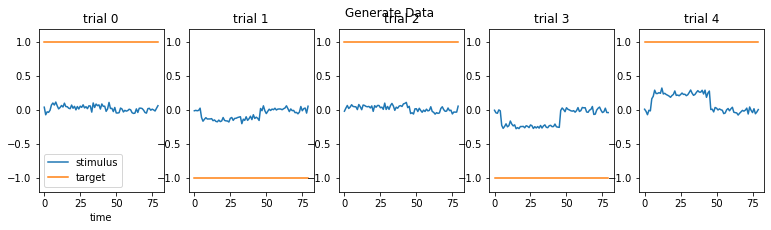

In [5]:
# plot

fig, axs = plt.subplots(1, trials, figsize=(13,3))

fig.suptitle("Generate Data")

for i in range(trials):
    axs[i].plot(time, u[i,:], label="stimulus")
    axs[i].plot(time, y[i,:], label="target")
    axs[i].set_title(f"trial {i}")
    axs[i].set_ylim(-1.2, 1.2)
axs[0].set_xlabel("time")
axs[0].legend()
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

J matrix has to have two trainable vectors m, and n as parameters.

In [6]:

class LinearLayer(nn.Module):
    def __init__(self, N):
        super().__init__()
        tensor_m = torch.randn(N)
        self.m = nn.Parameter(tensor_m)
        
        tensor_n = torch.randn(N)
        self.n = nn.Parameter(tensor_n)
        
        tensor_I = torch.randn(N)
        self.I = nn.Parameter(tensor_I)
        
        tensor_w = torch.randn(N)
        self.w = nn.Parameter(tensor_w)

    def dynamics(self, x, u, tau):
        J_of_phi_x = torch.mv(torch.matmul(self.m.reshape(N,1), self.n.reshape(1,N)), torch.tanh(x.reshape(-1)))
        return 1/tau *(- x + J_of_phi_x + u * self.I)
    
    def forward_euler(self, x, u, tau, dt):
        return x + self.dynamics(x, u, tau) * dt
    
   

In [7]:
# Initialize.

N = 128
x = torch.randn(N)

tau = 0.1  # seconds
dt = 0.02  # seconds
u, y = generate_data(trials, T, stim_strength)
rnn = LinearLayer(N)

In [8]:
trial_nr = 0
out_record = []
for t in range(T):
    x = rnn.forward_euler(x, u[0, t], tau, dt)
    out = (y[trial_nr, t] - torch.matmul(rnn.w.reshape(1, N), torch.tanh(x).reshape(N,1))).pow(2)
    out_record.append(out)
    out.backward(retain_graph = True)
    rnn.m.grad

In [9]:
out_record

[tensor([[13.9469]], grad_fn=<PowBackward0>),
 tensor([[33.3112]], grad_fn=<PowBackward0>),
 tensor([[41.0292]], grad_fn=<PowBackward0>),
 tensor([[39.8278]], grad_fn=<PowBackward0>),
 tensor([[35.5761]], grad_fn=<PowBackward0>),
 tensor([[29.8142]], grad_fn=<PowBackward0>),
 tensor([[25.5100]], grad_fn=<PowBackward0>),
 tensor([[22.7662]], grad_fn=<PowBackward0>),
 tensor([[20.5562]], grad_fn=<PowBackward0>),
 tensor([[21.0616]], grad_fn=<PowBackward0>),
 tensor([[22.5074]], grad_fn=<PowBackward0>),
 tensor([[25.2230]], grad_fn=<PowBackward0>),
 tensor([[26.2952]], grad_fn=<PowBackward0>),
 tensor([[23.7842]], grad_fn=<PowBackward0>),
 tensor([[19.8396]], grad_fn=<PowBackward0>),
 tensor([[17.0811]], grad_fn=<PowBackward0>),
 tensor([[14.4543]], grad_fn=<PowBackward0>),
 tensor([[11.8932]], grad_fn=<PowBackward0>),
 tensor([[10.1079]], grad_fn=<PowBackward0>),
 tensor([[11.5187]], grad_fn=<PowBackward0>),
 tensor([[12.6922]], grad_fn=<PowBackward0>),
 tensor([[14.8361]], grad_fn=<PowB